# Local Averages

In [1]:
import numpy as np
import scipy as sp
import importlib
import seaborn as sns
import matplotlib.pyplot as plt
import pdb

import sys
sys.path.append("../../")
import pyApproxTools as pat
importlib.reload(pat)

%matplotlib inline

## Local Averages

Now we are interested in local averages - where we integrate $v(x)$ against some compactly supported molifier function $\varphi_\varepsilon$, that is we find $\int \varphi_{\varepsilon}(x - x_0) v(x) \, \mathrm{d} x$. We find a Riesz representer $\omega_{x_0, \varepsilon}$ of this local integration, that is we define
$$
\langle \omega_{x_0, \varepsilon}, v \rangle = \int \varphi_{\varepsilon}(x - x_0) v(x) \, \mathrm{d} x 
$$

In the case where $\varphi_{\varepsilon} = \mathbb{1}_{[x_0 - \varepsilon/2, x_0 + \varepsilon/2]}$, and our space is $H_0^1([0,1])$, we have that
$$
\omega_{x_0, \varepsilon}(x) = \frac{1}{\sqrt{x_0-\varepsilon/6 + x_0^2}}
\begin{cases}
(1-x_0) x & \text{for } x \le x_0-\varepsilon/2 \\
(1-x_0) x - \frac{1}{2}\frac{(x-(x_0-\varepsilon/2))^2}{\epsilon} & \text{for } x_0 - \varepsilon/2 < x \le x_0+\varepsilon/2 \\
x_0 (1 - x)  & \text{for } x > x_0 + \varepsilon/2
\end{cases}
$$


### Projections

First we just want to see the performance of the projection on to a basis of uniformly spaced local averages for $m\to\infty$ with a variety of $\varepsilon$. We test this against a single function that is made up of sinusoids with random coefficients, i.e.
$$
v(x) = \sum_{k=1}^N \frac{y_k}{1+k^2}\sin(k \pi x)
$$
where $y_k\sim \mathcal{U}([-1,1])$ are IID uniformly distributed.

We then produce, for a variety of $\varepsilon$ (from about $1\times 10^{-2}$ to $1\times 10^{-4}$) a series of evenly spaced local averages as our basis, i.e. we take
$$
W_m = \mathrm{span}\{ \omega_{x_k, \varepsilon} : x_k = \varepsilon/2 + k / m \text{ for } k=0\ldots m-1 \}
$$
for $m$ ranging from 10 to something higher. Note that this allows the local averages to overlap.

We then plot $\| v - P_{W_m} v \|_{H_0^1}$ against $m$ for each choice of $\varepsilon$.

In [2]:
# Lets test with a function made of random sinusoids with decaying coefficients... (i.e. in some)
num_components = 200
np.random.seed(1)
v_c = 2 * np.random.random(num_components) - 1
for i in range(1,num_components+1):
    v_c[i-1] *= 1.0 / (1.0 + i*i)
v = pat.FuncVector(params=[range(1,101)], coeffs=[v_c], funcs=['H1UISin'])

Wm_plot = pat.make_unif_avg_basis(10, 0.05)
v_W, v_c = Wm_plot.project(v, return_coeffs=True)

#epsilons = [5e-2, 2.5e-2, 1e-2, 5e-3, 2.5e-3, 1e-3, 5e-4]
adj = 1 / (100*num_components + 1)
epsilons = [5e-2, 2.5e-2, 1e-2, 5e-3, 2.5e-3, 1e-3, 5e-4]
m_range = range(10,200)
err = np.zeros((len(epsilons), len(m_range)))

# Compute projection error for various epsilon and m
print('Converging uniform local averages for epsilon = ', end='')
for i, epsilon in enumerate(epsilons):
    print(str(epsilon) + '... ', end='')
    for j, m in enumerate(m_range):
        Wm = pat.make_unif_avg_basis(m, epsilon-adj)
        v_W = Wm.project(v)
        err[i,j] = (v - v_W).norm()

Converging uniform local averages for epsilon = 0.05... 0.025... 0.01... 0.005... 0.0025... 0.001... 0.0005... 

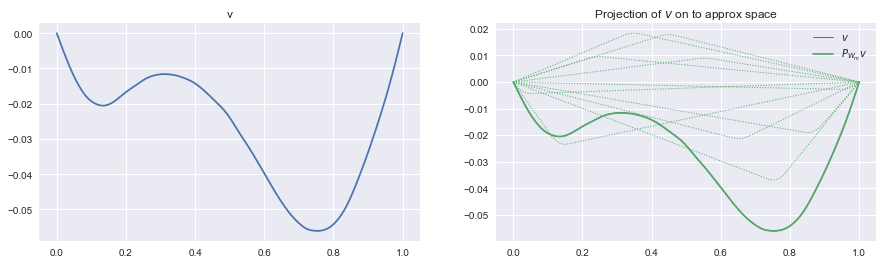

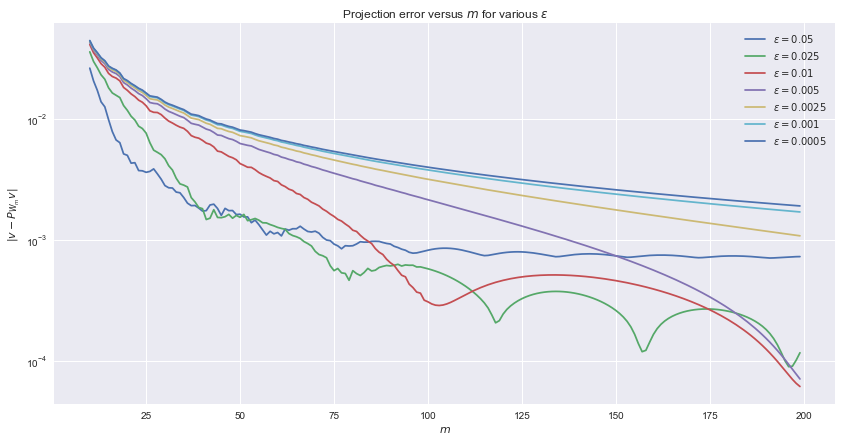

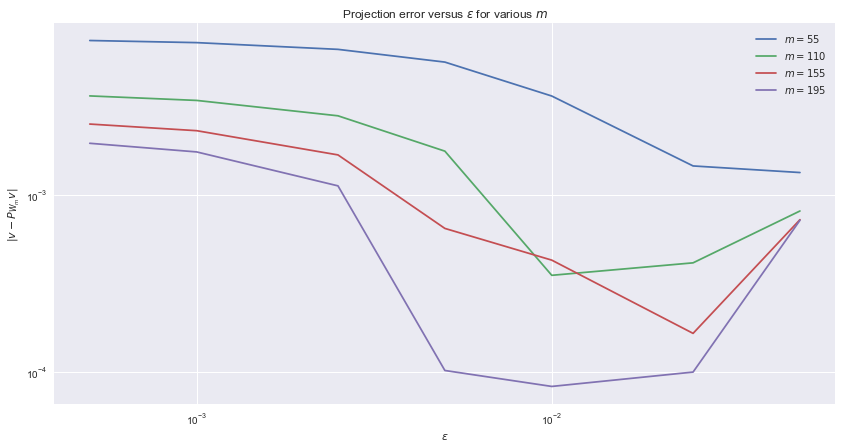

In [3]:
xs = np.arange(0.0, 1.005, 0.005)

sns.set_palette('deep')
cp = sns.color_palette()
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(1, 2, 1, title='v')
plt.plot(xs, v.evaluate(xs), label=r'$v$')
ax = fig.add_subplot(1, 2, 2, title='Projection of $v$ on to approx space')
plt.plot(xs, v.evaluate(xs), label=r'$v$', linewidth=1)
plt.plot(xs, v_W.evaluate(xs), label=r'$P_{W_m} v$')
for i in range(Wm_plot.n):
    plt.plot(xs, (Wm_plot.vecs[i].evaluate(xs))*v_c[i], ':', linewidth=1, color=cp[1])
plt.legend()
plt.show()

# Compute projection error for various epsilon and m
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(1, 1, 1, title=r'Projection error versus $m$ for various $\varepsilon$')
for i, epsilon in enumerate(epsilons):
    plt.semilogy(m_range, err[i,:], label=r'$\varepsilon={{{0}}}$'.format(epsilon))
ax.set(xlabel=r'$m$', ylabel=r'$\|v - P_{W_m} v\|$')
plt.legend()
plt.show()

# Pick some m and plot against epsilon...
ms = [55, 110, 155, 195]
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(1, 1, 1, title=r'Projection error versus $\varepsilon$ for various $m$')
for i, m_sel in enumerate(ms):
    plt.loglog(epsilons, err[:,m_range.index(m_sel)], label=r'$m={{{0}}}$'.format(m_sel))
ax.set(xlabel=r'$\varepsilon$', ylabel=r'$\|v - P_{W_m} v\|$')
plt.legend()
plt.show()

Note that there is a spike in error every time that $\varepsilon = 1/m$... This makes sense, but lets take a closer look at $m=20$ and $m=21$ when $\varepsilon=0.05, just to make sure something isn't going terribly wrong

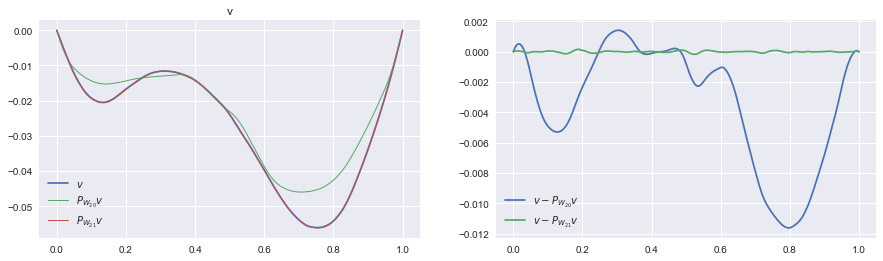

In [4]:
Wm = pat.make_unif_avg_basis(20, 0.05)
v_W, v_c = Wm.project(v, return_coeffs=True)
Wm2 = pat.make_unif_avg_basis(21, 0.05)
v_W2, v_c2 = Wm2.project(v, return_coeffs=True)

xs = np.arange(0.0, 1.005, 0.005)

sns.set_palette("deep",8)
cp = sns.color_palette()
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(1, 2, 1, title='v')
plt.plot(xs, v.evaluate(xs), label=r'$v$')
plt.plot(xs, v_W.evaluate(xs), label=r'$P_{W_{20}} v$', linewidth=1)
plt.plot(xs, v_W2.evaluate(xs), label=r'$P_{W_{21}} v$', linewidth=1)
plt.legend()
ax = fig.add_subplot(1, 2, 2, title='')
plt.plot(xs, (v-v_W).evaluate(xs), label=r'$v - P_{W_{20}} v$')
plt.plot(xs, (v-v_W2).evaluate(xs), label=r'$v - P_{W_{21}} v$')
plt.legend()
plt.show()

### Now we try the Collective OMP and Worst-Case OMP algorithms for this problem

We look at the results both with $\varepsilon=0.01$ and $0.0025$ for both algorithms

In [2]:
N = 1e3
eps_1 = 0.025
eps_2 = 0.01
eps_3 = 0.0025
dictionaries = [pat.make_unif_dictionary(N), pat.make_unif_avg_dictionary(N, eps_1),\
                pat.make_unif_avg_dictionary(N, eps_2), pat.make_unif_avg_dictionary(N, eps_3)]

ns = [20,40]
np.random.seed(3)
#n = 20
m = 150
bs_comp = np.zeros((len(ns), m, len(dictionaries)))
bs_wcomp = np.zeros((len(ns), m, len(dictionaries)))
bs_rand = np.zeros((len(ns), m))
bs_avg = np.zeros((len(ns), m))

Vn = pat.make_sin_basis(ns[-1])
Wms_comp = []
Wms_wcomp = []
Wms_avg = []
Wms_rand = []

for k, dictionary in enumerate(dictionaries):
    for j, n in enumerate(ns):

        gbc = pat.CollectiveOMP(dictionary, Vn.subspace(slice(0,n)), verbose=True)
        Wm_comp = gbc.construct_to_m(m)
        Wms_comp.append(Wm_comp)
        Wm_comp_o = Wm_comp.orthonormalise()

        wcgbc = pat.WorstCaseOMP(dictionary, Vn.subspace(slice(0,n)), verbose=True)
        Wm_wcomp = wcgbc.construct_to_m(m)
        Wms_wcomp.append(Wm_wcomp)
        Wm_wcomp_o = Wm_wcomp.orthonormalise()

        # For efficiency it makes sense to compute the basis pair and the associated
        # cross-gramian only once, then sub sample it as we grow m...
        BP_comp_l = pat.BasisPair(Wm_comp_o, Vn.subspace(slice(0,n)))
        BP_wcomp_l = pat.BasisPair(Wm_wcomp_o, Vn.subspace(slice(0,n)))

        for i in range(n, m):
            BP_comp = BP_comp_l.subspace(Wm_indices=slice(0,i))
            bs_comp[j, i, k] = BP_comp.beta()

            BP_wcomp =  BP_wcomp_l.subspace(Wm_indices=slice(0,i))
            bs_wcomp[j, i, k] = BP_wcomp.beta()

i 	 || P_Vn (w - P_Wm w) ||
1 : 	 81 	 0.8571343821013426
2 : 	 959 	 0.8478519661242144
3 : 	 814 	 0.5929925737817036
4 : 	 244 	 0.5199125278326097
5 : 	 26 	 0.48416159219343224
6 : 	 901 	 0.3199274022393139
7 : 	 679 	 0.29852256538188526
8 : 	 374 	 0.26312642476426895
9 : 	 151 	 0.26203418166487313
10 : 	 750 	 0.14756995955527202
11 : 	 603 	 0.13852504744923794
12 : 	 448 	 0.12731472282743972
13 : 	 308 	 0.12308941055655287
14 : 	 862 	 0.10431733420279948
15 : 	 194 	 0.08760532948172639
16 : 	 983 	 0.07296362498788497
17 : 	 116 	 0.05720132587427966
18 : 	 930 	 0.04963931221244638
19 : 	 47 	 0.04564995435059704
20 : 	 564 	 0.03924205166611702
21 : 	 716 	 0.03479393843544869
22 : 	 641 	 0.03430621290109172
23 : 	 485 	 0.032058761270104964
24 : 	 412 	 0.030850765953742608
25 : 	 782 	 0.028143467877218515
26 : 	 276 	 0.025898318452608114
27 : 	 340 	 0.023928063825036865
28 : 	 219 	 0.012521433198424392
29 : 	 11 	 0.012498860576901333
30 : 	 838 	 0.01208233637

90 : 	 61 	 0.00864260690752934
91 : 	 159 	 0.006106265866732241
92 : 	 789 	 0.006499483476644932
93 : 	 12 	 0.007516622169718309
94 : 	 818 	 0.005643232968780887
95 : 	 234 	 0.006209006582512458
96 : 	 267 	 0.005840197491789767
97 : 	 935 	 0.00592600290127375
98 : 	 952 	 0.006075354749429662
99 : 	 417 	 0.005064753645565551
100 : 	 546 	 0.00497763856211865
101 : 	 670 	 0.005034523321115744
102 : 	 29 	 0.004767705272884448
103 : 	 328 	 0.0044768699146102015
104 : 	 403 	 0.005082875054931296
105 : 	 642 	 0.004895029290965747
106 : 	 831 	 0.004435295335588348
107 : 	 205 	 0.004730571737459069
108 : 	 901 	 0.004790455354849052
109 : 	 83 	 0.005060423472026801
110 : 	 682 	 0.004753831010691725
111 : 	 506 	 0.004059391385082857
112 : 	 122 	 0.004682752626127024
113 : 	 804 	 0.004908607919784702
114 : 	 366 	 0.005500394996606636
115 : 	 656 	 0.00462031742466875
116 : 	 280 	 0.004901674721730809
117 : 	 304 	 0.00454275813225842
118 : 	 110 	 0.004676715770708301
119

30 : 	 328 	 0.13003944099350867
31 : 	 384 	 0.10526844107829396
32 : 	 259 	 0.11059424017049832
33 : 	 735 	 0.14772415350211562
34 : 	 468 	 0.09917130843364079
35 : 	 686 	 0.13868800612701776
36 : 	 519 	 0.11480995010354067
37 : 	 307 	 0.15300716328716824
38 : 	 564 	 0.12229360477344697
39 : 	 636 	 0.16977085473854905
40 : 	 426 	 0.08477682145527972
41 : 	 16 	 0.0799616244308099
42 : 	 483 	 0.06417252536230068
43 : 	 68 	 0.05153382341036987
44 : 	 879 	 0.060875353840895235
45 : 	 344 	 0.08059573500449246
46 : 	 774 	 0.062524095583998
47 : 	 170 	 0.06964594753162374
48 : 	 596 	 0.044028817757188705
49 : 	 94 	 0.050038319058295325
50 : 	 672 	 0.044456946084490745
51 : 	 196 	 0.051617447529264726
52 : 	 455 	 0.03732194986776331
53 : 	 826 	 0.05945730460000813
54 : 	 271 	 0.04235113485172454
55 : 	 980 	 0.16304251840139722
56 : 	 398 	 0.03441871675502502
57 : 	 723 	 0.04458167190277075
58 : 	 145 	 0.044208509502787194
59 : 	 647 	 0.03872123523130767
60 : 	 904

120 : 	 709 	 3.477034306442688e-09
121 : 	 157 	 3.4414443490758624e-09
122 : 	 74 	 3.3238102072764253e-09
123 : 	 646 	 2.975462187858186e-09
124 : 	 539 	 2.925090419691327e-09
125 : 	 518 	 3.0964073548637695e-09
126 : 	 480 	 3.0687191821786475e-09
127 : 	 469 	 3.200005710157781e-09
128 : 	 623 	 2.9771835882023363e-09
129 : 	 687 	 3.1926243887805377e-09
130 : 	 110 	 2.6254667753986996e-09
131 : 	 666 	 2.5273248655024456e-09
132 : 	 457 	 2.37621070762234e-09
133 : 	 852 	 2.289869289961791e-09
134 : 	 564 	 2.2749104212964486e-09
135 : 	 553 	 2.934512041826876e-09
136 : 	 730 	 2.3204062697545718e-09
137 : 	 309 	 2.265719654119114e-09
138 : 	 319 	 2.4424166783514617e-09
139 : 	 30 	 2.1373141571063955e-09
140 : 	 22 	 2.8877732562114358e-09
141 : 	 793 	 2.1172551517273846e-09
142 : 	 493 	 1.938618219302996e-09
143 : 	 529 	 2.11962559177708e-09
144 : 	 398 	 1.8171575104472169e-09
145 : 	 968 	 1.805387385705172e-09
146 : 	 720 	 1.7806640444702097e-09
147 : 	 587 	 1.7

58 : 	 40 	 7.651056897200806e-05
59 : 	 100 	 7.024252992140264e-05
60 : 	 531 	 5.192647010909956e-05
61 : 	 589 	 3.306481310178967e-05
62 : 	 981 	 2.771364132367408e-05
63 : 	 18 	 2.688943866626298e-05
64 : 	 761 	 2.2580746565454054e-05
65 : 	 471 	 1.5078187269582335e-05
66 : 	 250 	 1.3683139870730904e-05
67 : 	 939 	 1.0048234570528269e-05
68 : 	 121 	 1.0027628467141852e-05
69 : 	 645 	 9.37408759367364e-06
70 : 	 367 	 7.892535499976894e-06
71 : 	 877 	 7.74313699941107e-06
72 : 	 918 	 6.2723563470654795e-06
73 : 	 60 	 6.040593497489101e-06
74 : 	 803 	 5.663380677889547e-06
75 : 	 740 	 5.041069199906925e-06
76 : 	 80 	 4.624152708138445e-06
77 : 	 271 	 4.542718899091359e-06
78 : 	 416 	 4.313683001977686e-06
79 : 	 781 	 3.0781576402333636e-06
80 : 	 231 	 2.9322442584351563e-06
81 : 	 697 	 2.394948506350349e-06
82 : 	 211 	 1.7156321887961917e-06
83 : 	 318 	 1.5652149045842487e-06
84 : 	 480 	 1.5046701157106118e-06
85 : 	 637 	 1.4186167573300781e-06
86 : 	 841 	 1

143 : 	 765 	 7.205249945987924e-05
144 : 	 584 	 6.230767956418373e-05
145 : 	 282 	 0.00010801558265692568
146 : 	 196 	 6.897950451312945e-05
147 : 	 776 	 5.70780225849811e-05
148 : 	 80 	 0.00010337762064831224
149 : 	 401 	 6.716291836662142e-05


Done!
i 	 || P_Vn (w - P_Wm w) ||
1 : 	 35 	 0.8880884689850126
2 : 	 964 	 0.8804593572338302
3 : 	 185 	 0.634208989317624
4 : 	 817 	 0.6005777868909143
5 : 	 341 	 0.34097560057809984
6 : 	 94 	 0.3318789456245778
7 : 	 906 	 0.32780635856923784
8 : 	 681 	 0.2990960612034083
9 : 	 260 	 0.16870959428791335
10 : 	 431 	 0.15776108174524586
11 : 	 753 	 0.14709984144948185
12 : 	 604 	 0.13779465196691246
13 : 	 135 	 0.1114426023284553
14 : 	 865 	 0.10813244469780589
15 : 	 10 	 0.056303987848324515
16 : 	 989 	 0.056147158611463535
17 : 	 477 	 0.05603746360188586
18 : 	 384 	 0.05292798973829839
19 : 	 223 	 0.044734135521508456
20 : 	 65 	 0.04234961538030789
21 : 	 300 	 0.040188299880938604
22 : 	 935 	 0.03919290173293631
23 

82 : 	 739 	 0.006302670401080873
83 : 	 991 	 0.004561571284086907
84 : 	 775 	 0.0031610760859369647
85 : 	 939 	 0.00322609621910383
86 : 	 956 	 0.0032827128923932913
87 : 	 57 	 0.0019771916771922082
88 : 	 40 	 0.002297496171548341
89 : 	 266 	 0.0015967961812591303
90 : 	 836 	 0.0018242996351395813
91 : 	 821 	 0.0017629217551551751
92 : 	 251 	 0.0018558880308584685
93 : 	 790 	 0.00177382575334728
94 : 	 156 	 0.0012075112357200074
95 : 	 6 	 0.0016054342984971326
96 : 	 806 	 0.0017016758553953792
97 : 	 208 	 0.0011528564144785147
98 : 	 236 	 0.0014909478033605233
99 : 	 143 	 0.0013483361197863808
100 : 	 317 	 0.0009644979136591292
101 : 	 222 	 0.0010655262384236808
102 : 	 652 	 0.0009503040660887724
103 : 	 850 	 0.0014272086905190717
104 : 	 195 	 0.0015185696807309967
105 : 	 106 	 0.0007386610253662523
106 : 	 640 	 0.0007337272450047699
107 : 	 889 	 0.0007511534550411481
108 : 	 679 	 0.0006458622546475501
109 : 	 292 	 0.0005445166563111947
110 : 	 863 	 0.00076

18 : 	 741 	 0.11121932990261843
19 : 	 666 	 0.13390375549204586
20 : 	 109 	 0.15696670507451022
21 : 	 252 	 0.11308523830097979
22 : 	 894 	 0.13220229781905615
23 : 	 943 	 0.1400097765752983
24 : 	 131 	 0.11010957176918414
25 : 	 303 	 0.12540709418544654
26 : 	 463 	 0.13126676862915437
27 : 	 538 	 0.09677394391293592
28 : 	 641 	 0.11796745823488386
29 : 	 835 	 0.15619897013278716
30 : 	 280 	 0.10499281955629636
31 : 	 436 	 0.10570259545935796
32 : 	 181 	 0.10200808120293683
33 : 	 386 	 0.08540845710025487
34 : 	 814 	 0.14023333620542294
35 : 	 691 	 0.1068183799286101
36 : 	 231 	 0.11968828880286873
37 : 	 765 	 0.1438746833740314
38 : 	 585 	 0.11061060481277679
39 : 	 517 	 0.1068921825079099
40 : 	 348 	 0.07257963256772762
41 : 	 481 	 0.09081796866279322
42 : 	 14 	 0.12272128698748457
43 : 	 880 	 0.07753099073806341
44 : 	 627 	 0.04561717134273769
45 : 	 67 	 0.055608799092616734
46 : 	 266 	 0.043384912020169114
47 : 	 423 	 0.03706585160562319
48 : 	 984 	 0

108 : 	 209 	 0.00010841454335447683
109 : 	 817 	 5.614666875325412e-05
110 : 	 143 	 4.210707279292311e-05
111 : 	 854 	 3.99008800898981e-05
112 : 	 179 	 3.9386006057214204e-05
113 : 	 830 	 3.696784762681057e-05
114 : 	 167 	 3.643515109569368e-05
115 : 	 155 	 3.628598449619273e-05
116 : 	 842 	 3.580985505695077e-05
117 : 	 132 	 2.2245877453779365e-05
118 : 	 122 	 2.179280411102443e-05
119 : 	 865 	 2.1790582249864997e-05
120 : 	 875 	 2.2358007466586606e-05
121 : 	 585 	 2.0391205538894754e-05
122 : 	 597 	 2.0369005921764826e-05
123 : 	 539 	 1.937243059389921e-05
124 : 	 551 	 1.991838991517323e-05
125 : 	 885 	 1.885101120587915e-05
126 : 	 895 	 1.9381283524094278e-05
127 : 	 493 	 1.878400904984556e-05
128 : 	 505 	 1.9992779338182782e-05
129 : 	 102 	 1.8656779418166163e-05
130 : 	 112 	 1.9855413341180218e-05
131 : 	 970 	 1.7572330887495287e-05
132 : 	 574 	 1.497616400794321e-05
133 : 	 563 	 1.506201008870994e-05
134 : 	 620 	 1.4559970928858526e-05
135 : 	 609 	 1.

49 : 	 76 	 0.011630952842464725
50 : 	 947 	 0.008945808385253313
51 : 	 52 	 0.008792356219771112
52 : 	 924 	 0.008614946230050501
53 : 	 995 	 0.008326718300861522
54 : 	 4 	 0.00832671820761663
55 : 	 141 	 0.008282547425344525
56 : 	 167 	 0.007993278686604027
57 : 	 840 	 0.006858211642444193
58 : 	 33 	 0.006306520961920739
59 : 	 966 	 0.006306464271545633
60 : 	 863 	 0.004885990472370788
61 : 	 99 	 0.004092079324355177
62 : 	 119 	 0.0038365038316233793
63 : 	 903 	 0.0036511585644630035
64 : 	 499 	 0.003627220856988053
65 : 	 981 	 0.0033990129724838477
66 : 	 18 	 0.0033990128967670637
67 : 	 884 	 0.0032696697006745178
68 : 	 403 	 0.003258146739839249
69 : 	 451 	 0.0031591145581843917
70 : 	 427 	 0.003069706105550227
71 : 	 475 	 0.0030050796236466516
72 : 	 357 	 0.002945998463454185
73 : 	 569 	 0.0027326798616131914
74 : 	 380 	 0.002721156495664431
75 : 	 546 	 0.0026241689193464844
76 : 	 679 	 0.002621732382800041
77 : 	 636 	 0.0025711716771110167
78 : 	 334 	

139 : 	 112 	 0.007667202436572582
140 : 	 783 	 0.00667196851746045
141 : 	 341 	 0.005852932365936078
142 : 	 561 	 0.0061754480967413095
143 : 	 707 	 0.007005339993969004
144 : 	 267 	 0.01031159815714991
145 : 	 695 	 0.007227850730781443
146 : 	 985 	 0.013065471324786998
147 : 	 279 	 0.007313562271027418
148 : 	 572 	 0.007554234954940009
149 : 	 933 	 0.01324118953350581


Done!


In [3]:
for j, n in enumerate(ns):

    Wm_rand = pat.make_random_avg_basis(m, epsilon=1.0e-2)
    Wms_rand.append(Wm_rand)
    Wm_rand_o = Wm_rand.orthonormalise()

    # For efficiency it makes sense to compute the basis pair and the associated
    # cross-gramian only once, then sub sample it as we grow m...
    BP_rand_l = pat.BasisPair(Wm_rand_o, Vn.subspace(slice(0,n)))

    for i in range(n, m):
        BP_rand = BP_rand_l.subspace(Wm_indices=slice(0,i))
        bs_rand[j, i] = BP_rand.beta()

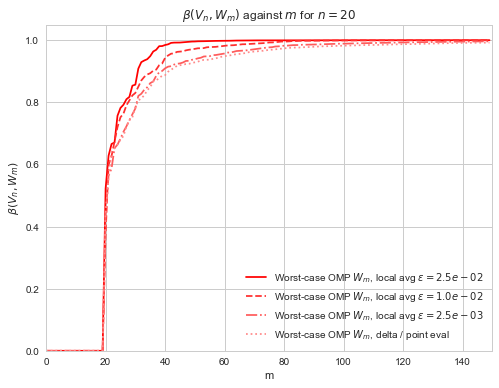

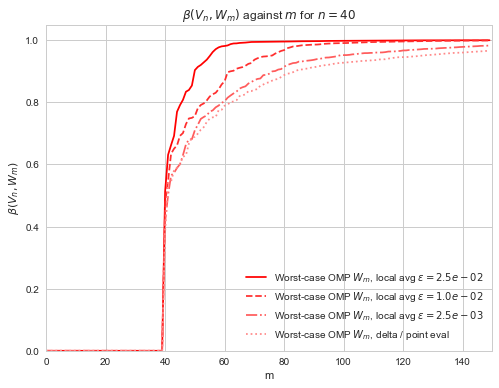

In [4]:
dict_label = [r'delta / point eval', r'local avg $\varepsilon={{{0:0.1e}}}$'.format(eps_1), \
              r'local avg $\varepsilon={{{0:0.1e}}}$'.format(eps_2), \
              r'local avg $\varepsilon={{{0:0.1e}}}$'.format(eps_3)]

line_style = ['-', '--', '-.', ':']

sns.set_palette("deep")
cp = sns.color_palette()
sns.set_palette(sns.light_palette("red", reverse=True))

sns.set_style('whitegrid')

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1, title=r'$\beta(V_n, W_m)$ against $m$ for $n=20$')

for k, dictionary in enumerate(dictionaries[1:]):
    plt.plot(range(m), bs_wcomp[0, :, k+1], line_style[k], label=r'Worst-case OMP $W_m$, {0}'.format(dict_label[k+1]))
plt.plot(range(m), bs_wcomp[0, :, 0], line_style[-1], label=r'Worst-case OMP $W_m$, {0}'.format(dict_label[0]))
#plt.plot(range(m), bs_rand[0, :], '-.', label=r'Random Wm'.format(n), color=cp[4])

ax.set(xlabel='m', ylabel=r'$\beta(V_n, W_m)$', xlim=[0,150], ylim=[0.,1.05])
plt.legend(loc=4)
plt.savefig('WCOMPAvgVsDelta_20.pdf')
plt.show()

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1, title=r'$\beta(V_n, W_m)$ against $m$ for $n=40$')

for k, dictionary in enumerate(dictionaries[1:]):
    plt.plot(range(m), bs_wcomp[1, :, k+1], line_style[k], label=r'Worst-case OMP $W_m$, {0}'.format(dict_label[k+1]))
plt.plot(range(m), bs_wcomp[1, :, 0], line_style[-1], label=r'Worst-case OMP $W_m$, {0}'.format(dict_label[0]))
#plt.plot(range(m), bs_rand[1, :], '-.', label=r'Random Wm'.format(n), color=cp[4])

ax.set(xlabel='m', ylabel=r'$\beta(V_n, W_m)$', xlim=[0,150], ylim=[0.,1.05])
plt.legend(loc=4)
plt.savefig('WCOMPAvgVsDelta_40.pdf')
plt.show()

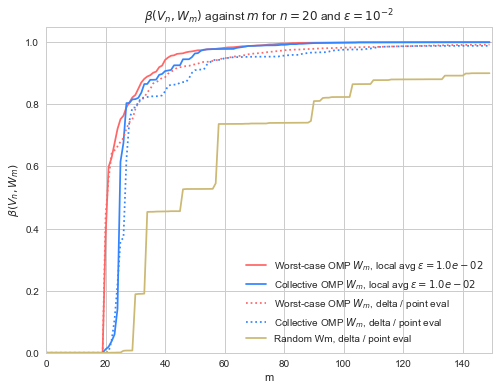

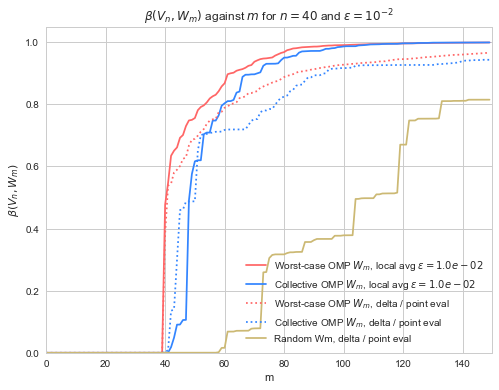

In [6]:
line_style = ['-', '--', '-.', ':']

sns.set_palette("deep")
cp = sns.color_palette()
bl = (51/255, 133/255, 255/255)
re = (255/255, 102/255, 102/255)

sns.set_style('whitegrid')

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1, title=r'$\beta(V_n, W_m)$ against $m$ for $n=20$ and $\varepsilon=10^{-2}$')

k = 2
plt.plot(range(m), bs_wcomp[0, :, k], label=r'Worst-case OMP $W_m$, {0}'.format(dict_label[k]), color=re)
plt.plot(range(m), bs_comp[0, :, k], label=r'Collective OMP $W_m$, {0}'.format(dict_label[k]), color=bl)
k = 0
plt.plot(range(m), bs_wcomp[0, :, k], ':', label=r'Worst-case OMP $W_m$, {0}'.format(dict_label[k]), color=re)
plt.plot(range(m), bs_comp[0, :, k], ':', label=r'Collective OMP $W_m$, {0}'.format(dict_label[k]), color=bl)
plt.plot(range(m), bs_rand[0, :], label=r'Random Wm, {0}'.format(dict_label[k]), color=cp[4])

ax.set(xlabel='m', ylabel=r'$\beta(V_n, W_m)$', xlim=[0,150], ylim=[0.,1.05])
plt.legend(loc=4)
plt.savefig('COMPvsWCOMPAvg_20.pdf')
plt.show()

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1, title=r'$\beta(V_n, W_m)$ against $m$ for $n=40$ and $\varepsilon=10^{-2}$')

k = 2
plt.plot(range(m), bs_wcomp[1, :, k], label=r'Worst-case OMP $W_m$, {0}'.format(dict_label[k]), color=re)
plt.plot(range(m), bs_comp[1, :, k], label=r'Collective OMP $W_m$, {0}'.format(dict_label[k]), color=bl)
k = 0
plt.plot(range(m), bs_wcomp[1, :, k], ':', label=r'Worst-case OMP $W_m$, {0}'.format(dict_label[k]), color=re)
plt.plot(range(m), bs_comp[1, :, k], ':', label=r'Collective OMP $W_m$, {0}'.format(dict_label[k]), color=bl)

plt.plot(range(m), bs_rand[1, :], label=r'Random Wm, {0}'.format(dict_label[k]), color=cp[4])

ax.set(xlabel='m', ylabel=r'$\beta(V_n, W_m)$', xlim=[0,150], ylim=[0.,1.05])
plt.legend(loc=4)
plt.savefig('COMPvsWCOMPAvg_40.pdf')
plt.show()

### Plot the locations of the local averages chosen for $W_m$

This is a similar plot to that we saw in ```01_omp_collective.ipynb```, where the location of the local averages that is picked by that step is also shown (only possible because the range of $\beta$ is $[0,1]$, and the domain happens to also be $[0,1]$.

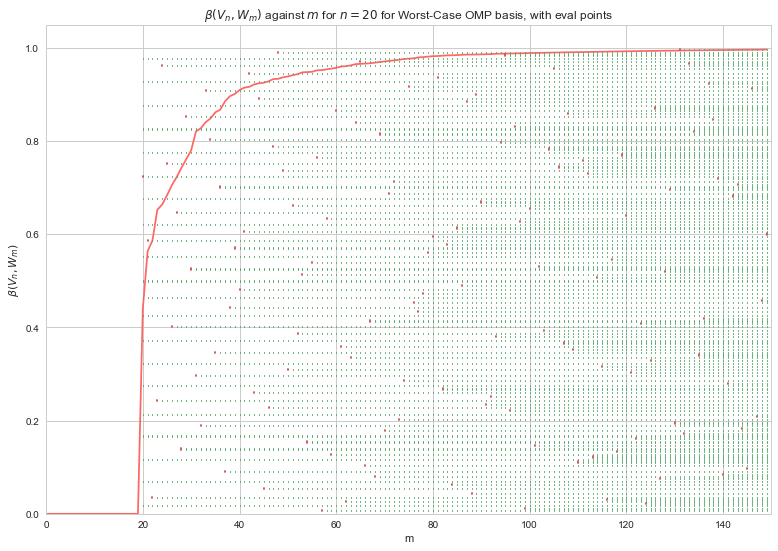

In [53]:
wc = 3 # The "width choice" in this case corresponds to 2.5e-3
nc = 0 # n choice 0 means 20
n = ns[nc]

Wm_wcomp = Wms_wcomp[2*wc + nc]
b_wcomp = bs_wcomp[nc,:,wc]
Wm_comp = Wms_comp[2*wc + nc]
b_comp = bs_comp[nc,:,wc]

# Plot the evaluation points in the Wm basss 
Wm_points = np.array([vec.params_array(0).flatten() for vec in Wm_wcomp.vecs])

line_style = ['-', '--', '-.', ':']

sns.set_palette("deep")
cp = sns.color_palette()
bl = (51/255, 133/255, 255/255)
re = (255/255, 102/255, 102/255)

sns.set_style('whitegrid')

axs = []
fig = plt.figure(figsize=(13, 9))
ax = fig.add_subplot(1, 1, 1, title=r'$\beta(V_n, W_m)$ against $m$ for $n={{{0}}}$ for Worst-Case OMP basis, with eval points'.format(n))
ax.set(xlabel=r'$m$', ylabel=r'$\beta(V_n, W_m)$ and point locations')

plt.plot(range(m), b_wcomp, color=re, label=r'$\beta(V_n, W_m)$ for OMP $W_m$')

for k in range(20,m):

    for j in range(k-1):
        plt.plot(k * np.ones(2), Wm_points[j,:], color=cp[1], label='eval intervals', linewidth=1)
    plt.plot(k * np.ones(2), Wm_points[k-1,:], color=cp[2], markersize=6, label='New eval point')

ax.set(xlabel='m', ylabel=r'$\beta(V_n, W_m)$', xlim=[0,150], ylim=[0.,1.05])
plt.savefig('WCOMPAvgLocations_{0}.pdf'.format(n))
plt.show()

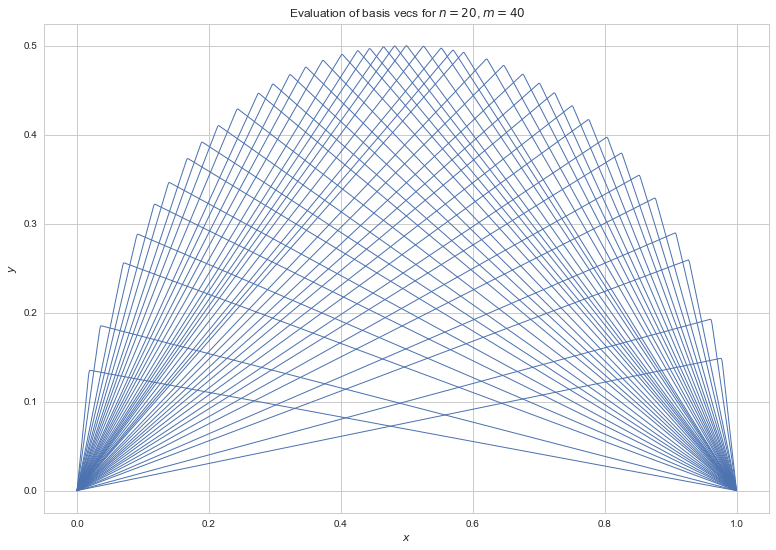

In [57]:
# Ok, so that's a more or less incomprehensible chart, what about just taking one step and checking it out?
k = 40
xs = np.arange(0,1.001,0.001)

axs = []
fig = plt.figure(figsize=(13, 9))
ax = fig.add_subplot(1, 1, 1, title=r'Evaluation of basis vecs for $n={{{0}}}$, $m={{{1}}}$'.format(n,k))
ax.set(xlabel=r'$x$', ylabel=r'$y$')

for j in range(k):
    plt.plot(xs, Wm_wcomp.vecs[j].evaluate(xs), color=cp[0], linewidth=1)

plt.savefig('WCOMPAvgEvaluations_{0}_{1}.pdf'.format(n, k))
plt.show()